---
# Deep Learning Assignment 1
---

### 0. Importing the necessary libraries 

In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

#from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 1. Data Exploration

We want to create a Neural Network which takes images of white Blood cells as input and should classify the type of cell, if the shape of the cell is round or irregular, the shape of the nucleus and if there are cytoplasm vacuoles in the cell. Let us take a look at some of the images and their target labels.

Firstly, we initialize the data paths and set the target size which will become relevant later when utilizing existing models such as ResNet and EfficientNet. Also we initialize a seed for reproducability purposes and look at our labels. 

In [3]:
seed = 1234
tf.random.set_seed(seed)

image_size = (224,224)

# image_path = '/home/ec2-user/SageMaker/data/Hematoxylin/'
# labels_path = '/home/ec2-user/SageMaker/data/'

image_path = 'data/Hematoxylin/'
labels_path = 'data/'

labels = pd.read_csv(labels_path + 'dev_data_2025.csv')
labels.head(5)

imageID       label cell_shape         nucleus_shape cytoplasm_vacuole
0  Img_00001  Lymphocyte      round     unsegmented-round                no
1  Img_00002    Monocyte  irregular  unsegmented-indented                no
2  Img_00003    Monocyte  irregular             irregular               yes
3  Img_00004    Basophil      round  segmented-multilobed                no
4  Img_00005  Neutrophil      round      unsegmented-band                no

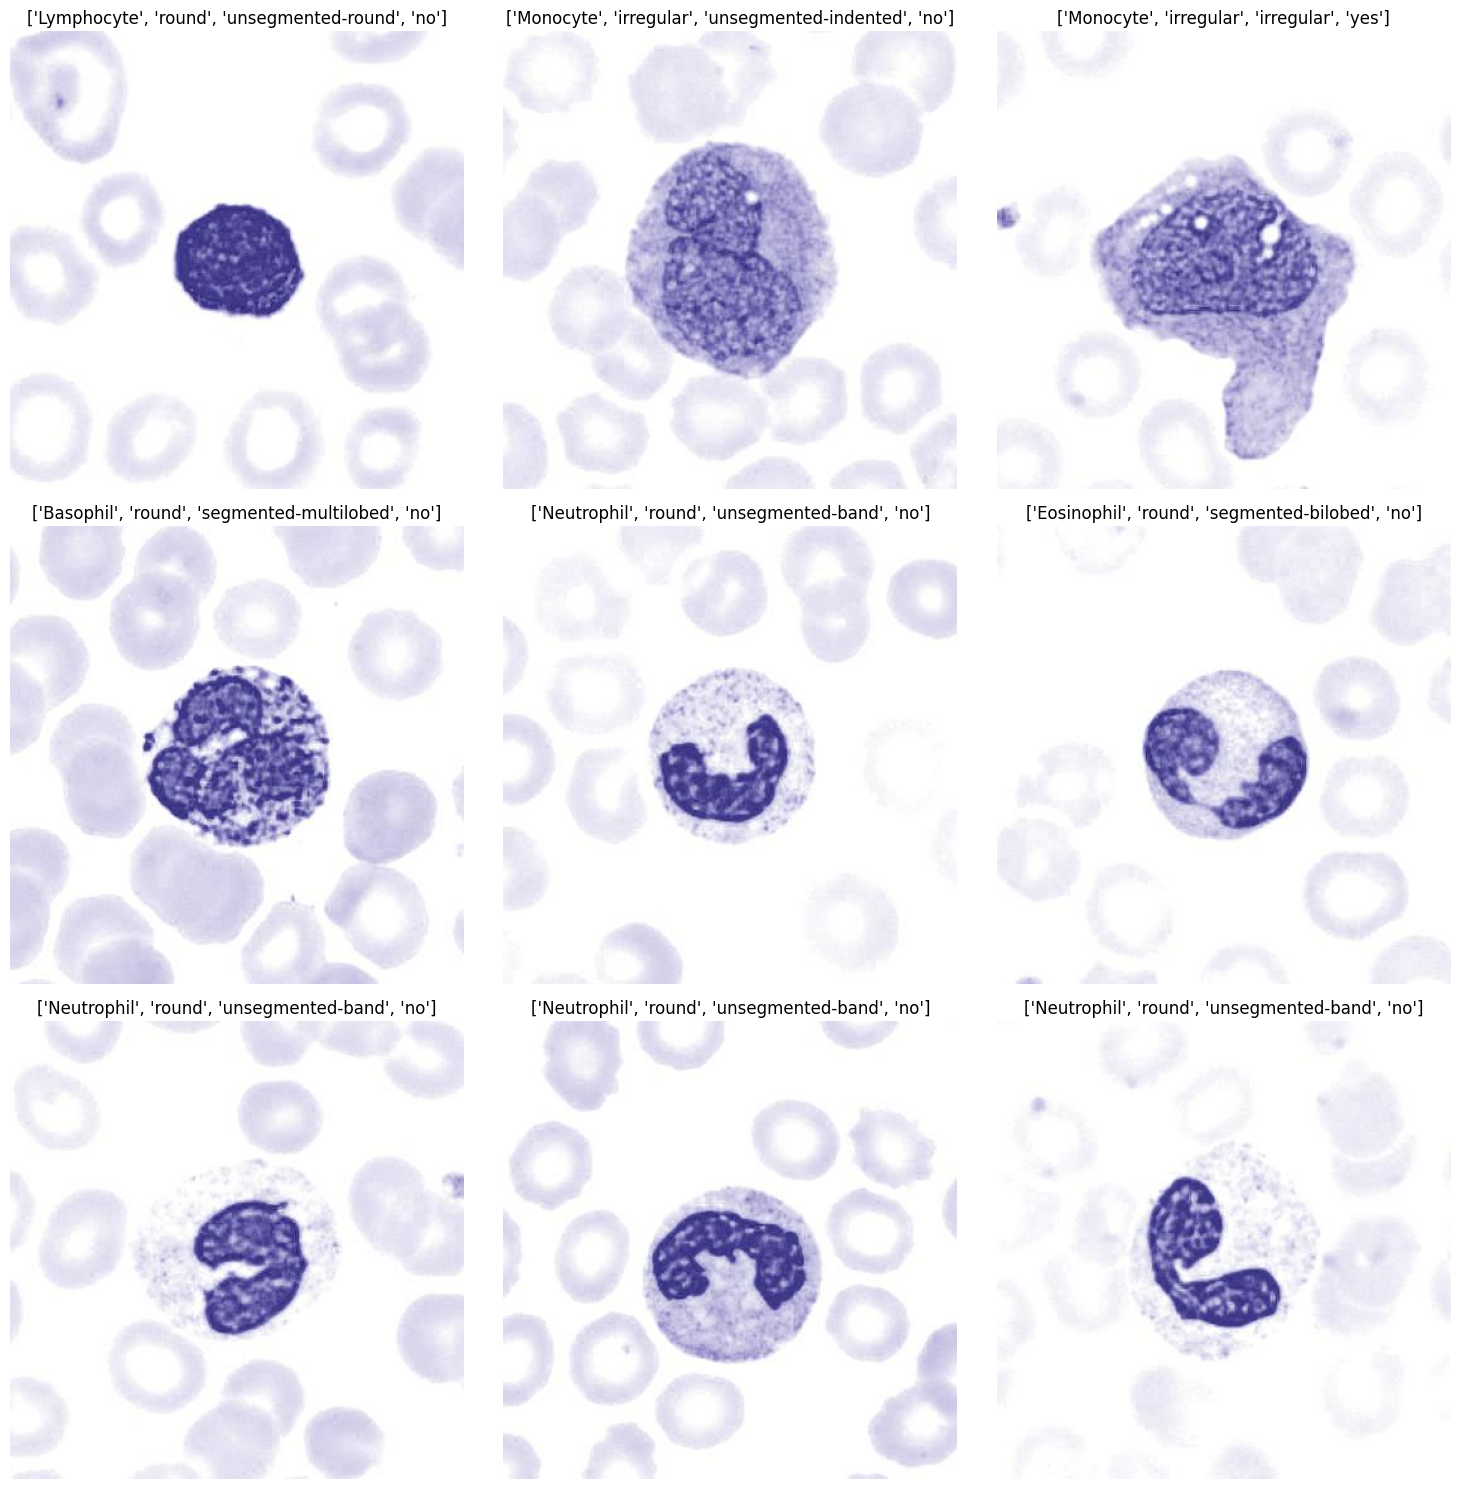

In [20]:
features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))  
axs = axs.flatten()

for i in range(9):
    current_labels = labels.iloc[i,:]
    image_filename = current_labels['imageID']

    path = tf.strings.join([image_path, image_filename, '.jpg'])
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    #image = tf.cast(image, tf.float32)

    axs[i].imshow(image)
    axs[i].set_title([current_labels[f] for f in features])
    axs[i].axis('off')

plt.tight_layout()
fig.savefig('images_pre_augment')


- The white blood cell is centrally placed in the image. When we are resizing onto the target size instead of keeping the image largely the same we can crop the outside off to not reduce the pixels in the important centre of the picture.
- The colour in the picture doesn't seem very important. We could try and change it into greyscale images to slightly reduce model complexity.
- Orientation of the images seems irrelevant giving us many opportunities to utilize data augmentations. 

Let us take a look at the distribution of labels to evaluate class imbalance.

C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_31008\3551195083.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(counts.index, rotation = 45)


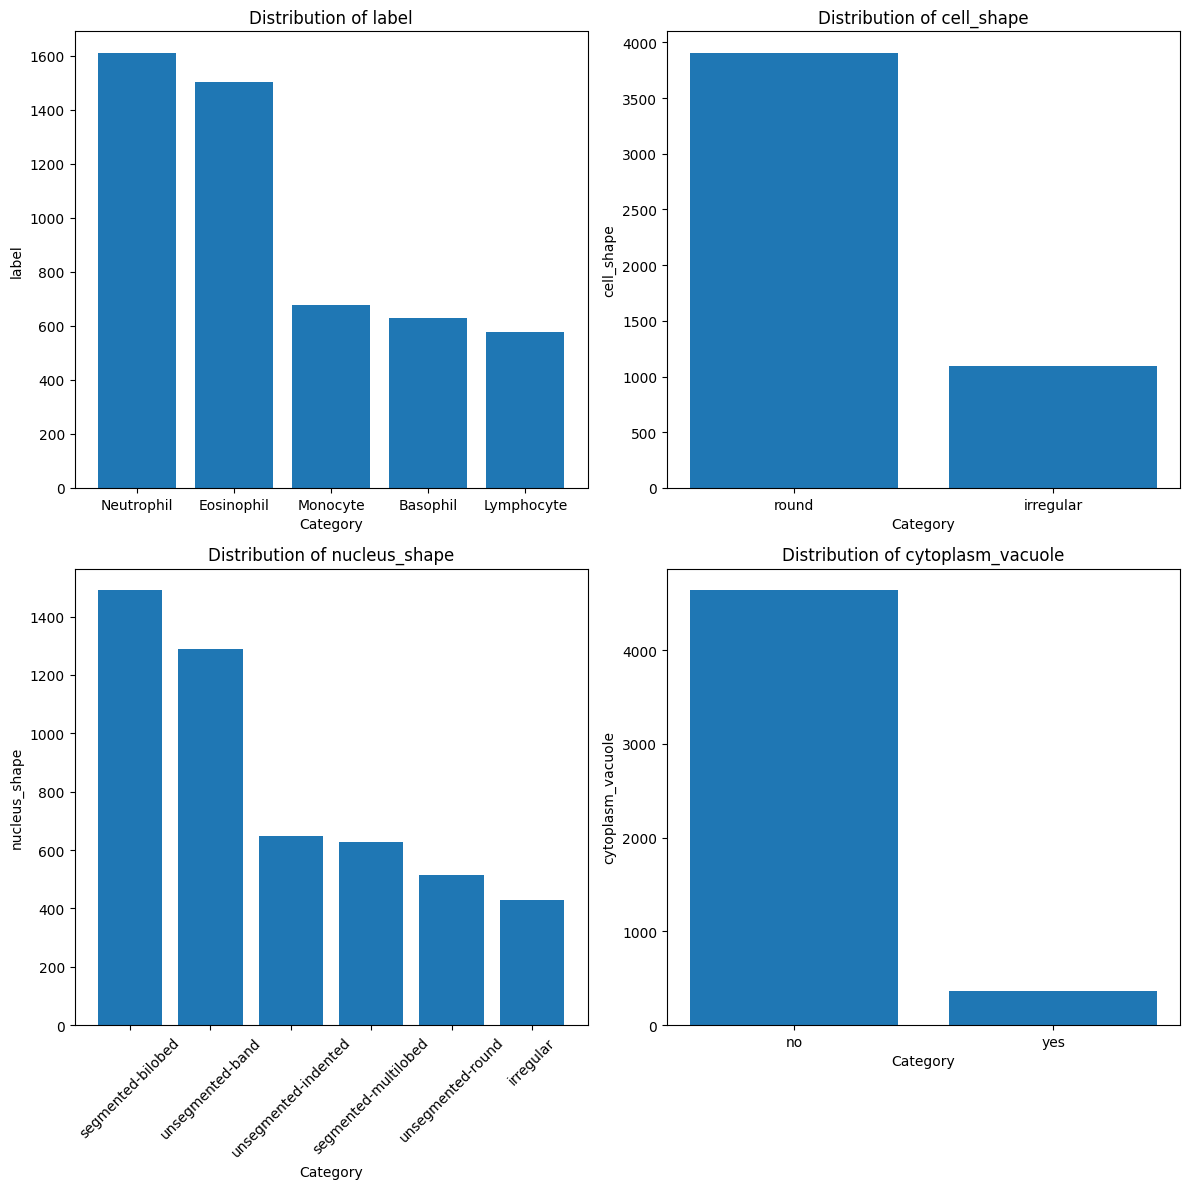

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  
axs = axs.flatten()

for i, feature in enumerate(features):
    counts = labels[feature].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel('Category')
    axs[i].set_ylabel(feature)
    
    if feature == 'nucleus_shape':
        axs[i].set_xticklabels(counts.index, rotation = 45)

plt.tight_layout()
plt.savefig('label_dist_pre.png')

- All of the predicted classes deal with variying levels of imbalance. This will definitely be an issue for the training process if we don't consider it. 
- To present the solution to this problem we have to jump ahead to data augmentations. As mentioned earlier, the dataset provides great opportunity to utilize them. With that in mind, my solution is to duplicate images with rare label combinations. The augmentations hopefully edit them in a way that they seem different enough to support the training process. To evaluate the model we will also utilize the f1_score to ensure the model trains effectively. Below is the implementation of an image multiplier.  

In [11]:
class Image_multiplier():
    '''
    fit: for each of the passed features classes, it will compute a rarity based on how less frequent the specific 
    class is to the most common class for that feature. That means for example the most common class will receive a rarity
    score of 1 while a class that appears three times less often will have a rarity of 3. 
    transform: For each observation in the dataset it will compute the product of the rarities of each feature. This is then 
    downscaled by a logarithmic function (otherwise the dataset size just exploded). 
    '''
    def __init__(self):
        self.rarities = {}
    
    def fit(self, labels, features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']):
        self.features = features
        for f in self.features:
            counts = labels[f].value_counts()
            max_count = counts.max()
            self.rarities[f] = {c: max_count / counts[c] for c in counts.index}

    def transform(self, labels):
        m_factors = []
        for _, row in labels.iterrows():
            raw_factors = np.prod([self.rarities[f][row[f]] for f in self.features])
            m_factors.append(int(np.floor(np.maximum(1, np.log(raw_factors)))))
        
        labels_repeated = labels.loc[labels.index.repeat(m_factors)].reset_index(drop=True)
        return labels_repeated

    def fit_transform(self, labels, features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']):
        self.fit(labels, features = features)
        return self.transform(labels)

We did quite a lot of testing with different downscaling variants of the rarity multiplication and ended up choosing the logarithmic downscaling. We just need to make sure that the minimum rarity (after transformation) remains at 1 as we don't want to delete data unnecessarily. Let us take a look at the changed distribution of labels and size of the training dataset. We obviously only want to apply this change to the training data. This does introduce an issue that the population distribution heavily differ between training and validation dataset which we will come back to later.  

In [12]:
data_train, data_val = train_test_split(labels, test_size=0.20, random_state=seed)

print(f'Size before image multiplication: {data_train.shape}')
im = Image_multiplier()
data_train = im.fit_transform(data_train)
print(f'Size after image multiplication: {data_train.shape}')

Size before image multiplication: (4000, 5)
Size after image multiplication: (6008, 5)


C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_31008\4203287191.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(counts.index, rotation = 45)


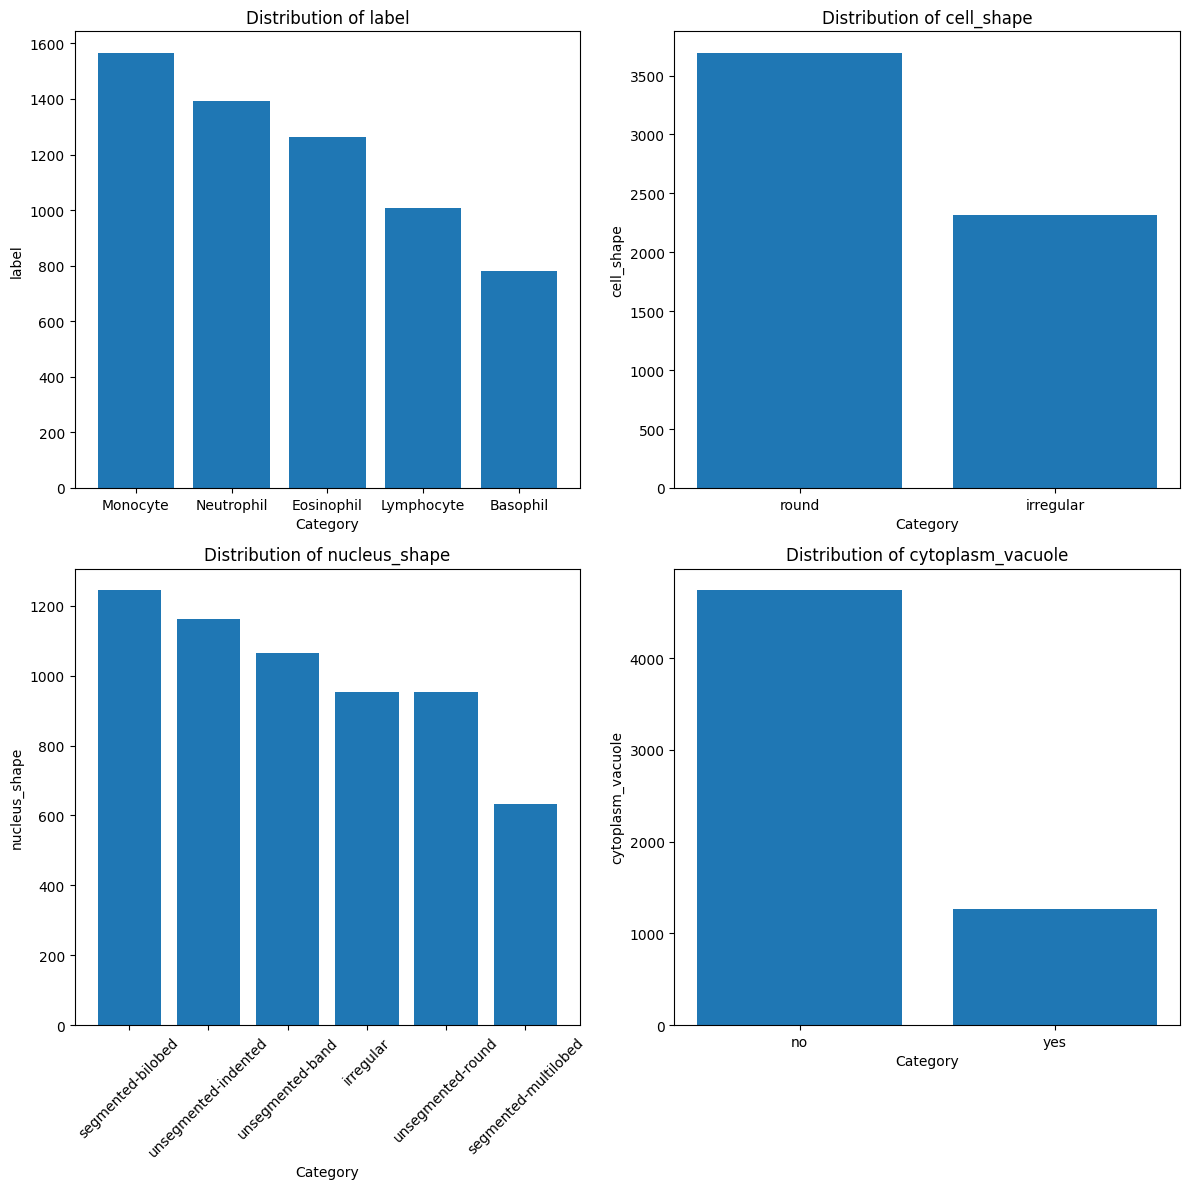

In [ ]:
features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  
axs = axs.flatten()

for i, feature in enumerate(features):
    counts = data_train[feature].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel('Category')
    axs[i].set_ylabel(feature)

    if feature == 'nucleus_shape':
        axs[i].set_xticklabels(counts.index, rotation = 45)

plt.tight_layout()
plt.savefig('label_dist_post.png')

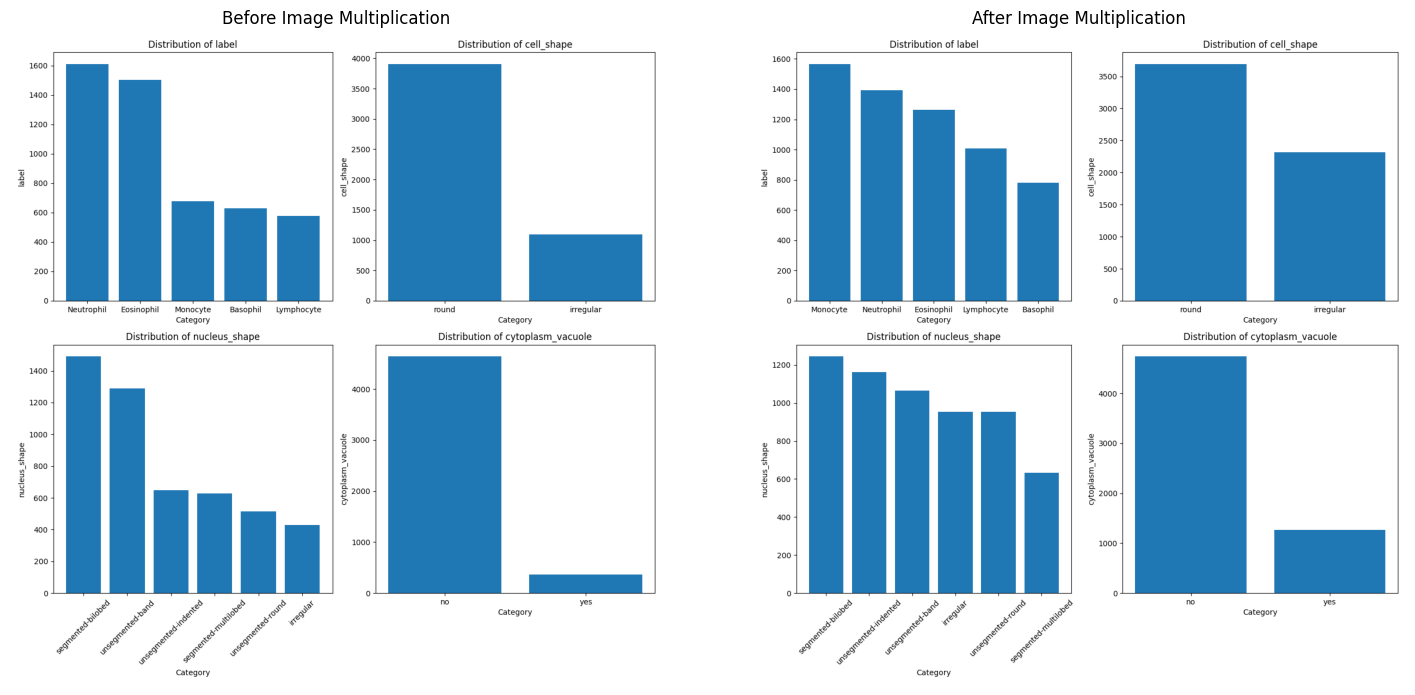

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(plt.imread('label_dist_pre.png'))
axs[0].set_title("Before Image Multiplication")
axs[0].axis("off")

axs[1].imshow(plt.imread('label_dist_post.png'))
axs[1].set_title("After Image Multiplication")
axs[1].axis("off")

plt.tight_layout()

This proves to be somewhat efficient in reducing the class imbalance and we will work with the multiplied images for our training data. 

## 2. Data Preprocessing

To ensure functionality of tensorflow and make sure we can identify the labels later on we create a mapping for each of the features to the natural numbers. Additionally, we create the reverse mappings to have a way back for future visualizations. 

In [18]:
mapping_cv = {'yes':1, 'no':0}
mapping_shape = {'round':0, 'irregular':1}
mapping_type = {'Neutrophil':0, 'Eosinophil':1, 'Monocyte':2, 'Basophil':3, 'Lymphocyte':4}
mapping_nucleus = {'segmented-bilobed':1, 'unsegmented-band':2, 'unsegmented-indented':3, 'segmented-multilobed':4, 'unsegmented-round':5, 'irregular':0}

data_train['label'] = data_train['label'].map(mapping_type)
data_train['cell_shape'] = data_train['cell_shape'].map(mapping_shape)
data_train['nucleus_shape'] = data_train['nucleus_shape'].map(mapping_nucleus)
data_train['cytoplasm_vacuole'] = data_train['cytoplasm_vacuole'].map(mapping_cv)

data_val['label'] = data_val['label'].map(mapping_type)
data_val['cell_shape'] = data_val['cell_shape'].map(mapping_shape)
data_val['nucleus_shape'] = data_val['nucleus_shape'].map(mapping_nucleus)
data_val['cytoplasm_vacuole'] = data_val['cytoplasm_vacuole'].map(mapping_cv)

rev_type = {v:k for k,v in mapping_type.items()}
rev_shape = {v:k for k,v in mapping_shape.items()}
rev_cv = {v:k for k,v in mapping_cv.items()}
rev_nucleus = {v:k for k,v in mapping_nucleus.items()}

We create our dependent and target variable separately. For now our dependent variable is simply the name of the image. This is visualized below.

In [19]:
image_names_train = data_train['imageID']
image_names_val = data_val['imageID']

y_train = data_train.drop(columns=['imageID'])
y_val = data_val.drop(columns=['imageID'])

X_train = [image + '.jpg' for image in image_names_train]
X_val = [image + '.jpg' for image in image_names_val]

train_size = len(X_train)
val_size = len(X_val)

In [11]:
print(X_train[:5])
print(y_train.head(5))

['Img_03701.jpg', 'Img_00895.jpg', 'Img_02323.jpg', 'Img_04593.jpg', 'Img_03712.jpg']
   label  cell_shape  nucleus_shape  cytoplasm_vacuole
0      1           0              1                  0
1      1           0              1                  0
2      0           0              2                  0
3      0           0              2                  0
4      1           1              1                  0


We define our own data augmentor to create our train and validation batches. The image preparation is split into two separate parts, the deterministic part (load_image) which is only applied once before caching and the random augmentations (augment) which are applied each epoch. The validation batches are not augmented to represent a realistic performance representation of the original dataset. There are a few options included such as treating the image as greyscale, and the reduction technique of cropping or resizing. 

For data augmentation we can consider:
- Flipping: As mentioned earlier orientation shouldn't matter so this easily creates 'more' images. 
- Rotation: Similar to flipping should prove to be quite effective. 
- Zoom: The cell size can differ based on the picture and should not matter for the classification. 
- Brightness: Slightly adjust the brightness. We had to be careful here as a higher value made many cell outlines invisible. 

In [31]:
def center_crop(image, target_size):
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    target_h = target_size[0]
    target_w = target_size[1]

    offset_h = (h - target_h) // 2
    offset_w = (w - target_w) // 2

    image = tf.image.crop_to_bounding_box(image, offset_h, offset_w, target_h, target_w)
    return image

def load_image(image_filename, label, resize_technique='crop', greyscale = False, need_dims = True):
  path = tf.strings.join([image_path, image_filename])
  image_raw = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image_raw, channels=3)
  image = tf.cast(image, tf.float32)

  if resize_technique == 'crop':
    image = center_crop(image, image_size)
  elif resize_technique == 'scale':
    image = tf.image.resize(image, image_size)
  else:
    print('WARNING: No valid resizing technique selected')

  if greyscale:
    image = tf.image.rgb_to_grayscale(image)
    if need_dims:
      image = tf.tile(image, [1, 1, 3])

  label_shape = label[1]
  label_cv = label[3]
  label_label = tf.one_hot(label[0], 5)
  label_nucleus = tf.one_hot(label[2], 6)

  label = (label_label, label_shape, label_nucleus, label_cv)
  return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomBrightness(0.1, value_range=[0,255]),
    tf.keras.layers.RandomZoom(height_factor=(-0.15, 0.15), width_factor=(-0.3, 0.3), fill_mode='reflect'), 
    tf.keras.layers.RandomRotation(0.2),
  ])

def augment(image ,labels, preprocess = True, augment=True):

  if augment == True:
    image = data_augmentation(image)

  if preprocess:
    image = preprocess_input(image)
  else:
    image = image/255 

  return image, labels

BATCH_SIZE = 32
NUM_EXAMPLES = train_size
NUM_EXAMPLES_VAL = val_size

train_batches = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .take(NUM_EXAMPLES)
    .map(lambda x,y: load_image(x,y), num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(buffer_size=NUM_EXAMPLES)
    .map(lambda x,y: augment(x,y), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_batches = (
  tf.data.Dataset.from_tensor_slices((X_val, y_val))
  .take(NUM_EXAMPLES_VAL)
  .map(lambda x,y: load_image(x,y), num_parallel_calls=AUTOTUNE)
  .cache()
  .map(lambda x, y: augment(x,y, augment=False), num_parallel_calls=AUTOTUNE)
  .batch(BATCH_SIZE)
  .prefetch(AUTOTUNE)
)


Let us take a look at some of the preprocessed images: 

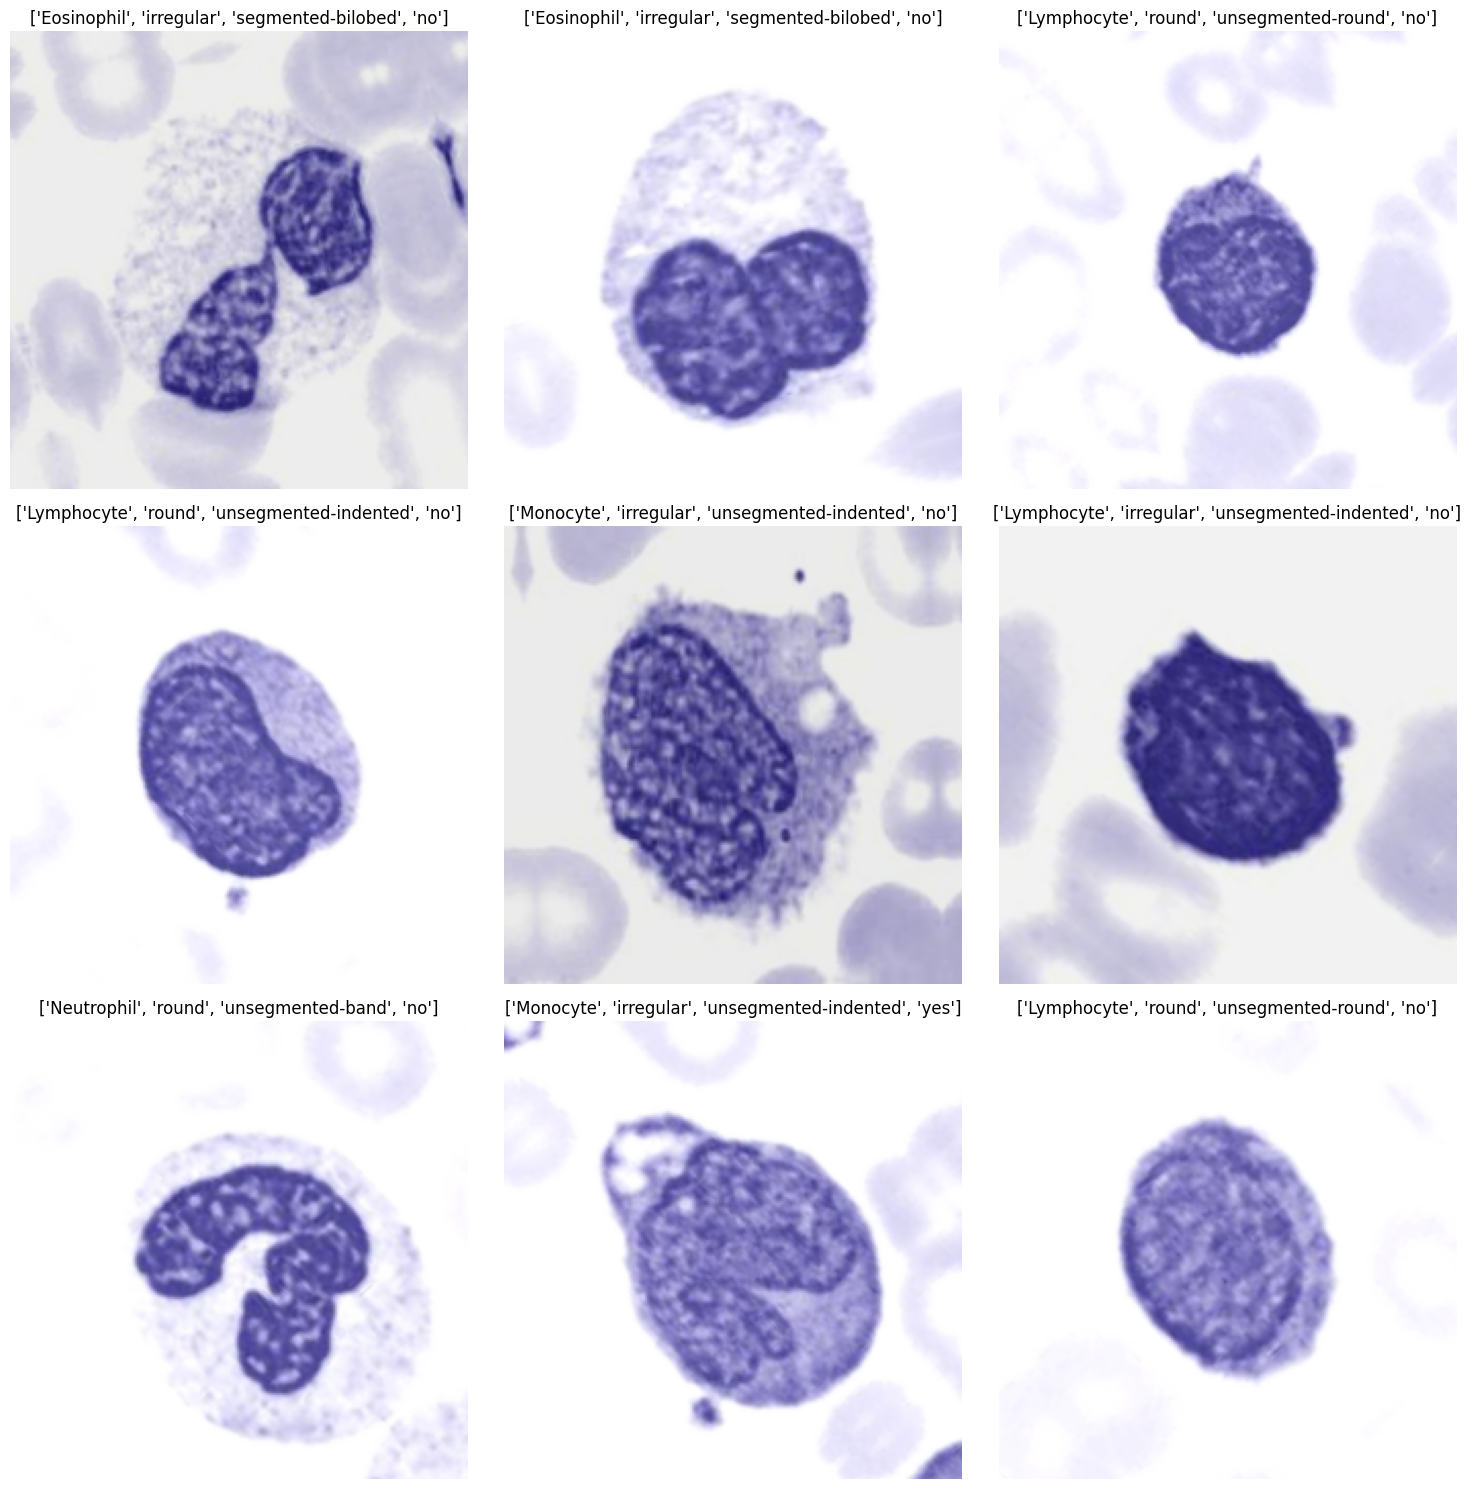

In [32]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
axs = axs.flatten()

for images, labels in train_batches.take(1):
    for i in range(9):
        label_type    = rev_type[tf.argmax(labels[0][i]).numpy()]
        label_shape   = rev_shape[labels[1][i].numpy()]
        label_nucleus = rev_nucleus[tf.argmax(labels[2][i]).numpy()]
        label_cv      = rev_cv[labels[3][i].numpy()]
        
        axs[i].imshow(images[i].numpy().astype(np.uint8))
        axs[i].axis('off')
        axs[i].set_title([label_type, label_shape, label_nucleus, label_cv])
    break

fig.tight_layout()
fig.savefig('images_post_augment.png')

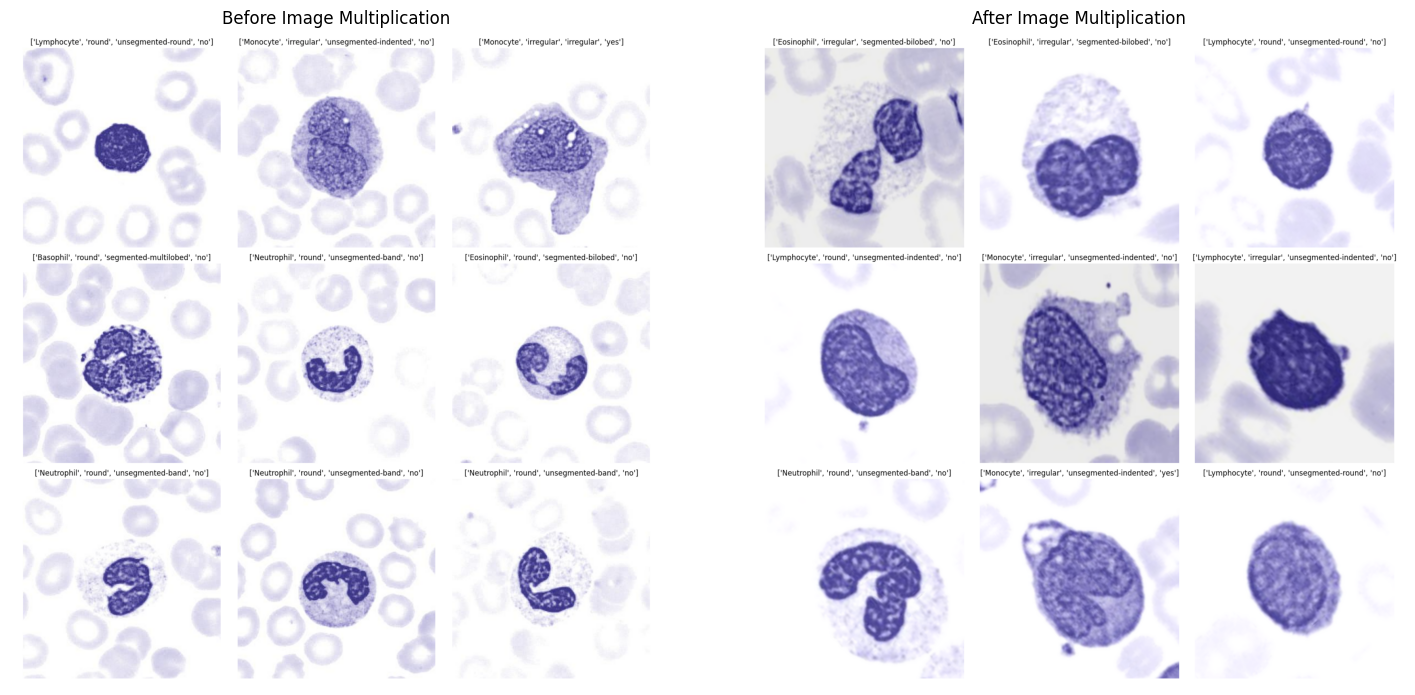

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(plt.imread('images_pre_augment.png'))
axs[0].set_title("Before Image Multiplication")
axs[0].axis("off")

axs[1].imshow(plt.imread('images_post_augment.png'))
axs[1].set_title("After Image Multiplication")
axs[1].axis("off")

plt.tight_layout()

- We are a lot more zoomed into the cell (rarely this will be too far, considering we also used zoom augmentations.)

## 3. Baseline Model

- Cell type: The main classification into five different types. This could consider quite a few different things and utilizes the whole cell.  
- Cell shape: Binary prediction of round or irregular. Should be determined mostly on the outline of the cell in similar positions. We just want to identify a singular circle so maybe a global maximum pooling could prove more efficient. However, the nucleus could also have round shapes. Should not need many features to identify.   
- Nucleus Shape: Can be at an arbitrary position and in different sizes. Could use a number of features and is only interested in the inside of the cell.  
- Cytoplasm Vaculole: Just need to be found at a single position, maybe max pooling could be more useful? 

The baseline model is insired by the architecture of ResNet and includes three Residual Blocks one after another. Those residual blocks consist of two convolutional layers where a potential change in size (controlled by the stride) and channels (controlled by n_channels) can be performed. The skip connection adapts to the changed size.  

In [34]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_channels, stride=1, dropout_fraction=0.2, activation=tf.keras.layers.ReLU):
        super().__init__()
        self.n_channels = n_channels
        self.stride = stride
        self.dropout_fraction = dropout_fraction
        self.activation = activation()

        self.conv1 = tf.keras.layers.Conv2D(n_channels, 3, strides=stride, padding='same', use_bias=False)
        self.conv2 = tf.keras.layers.Conv2D(n_channels, 3, strides=1, padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(dropout_fraction)
        self.drop2 = tf.keras.layers.Dropout(dropout_fraction)

        self.shortcut_conv = tf.keras.layers.Conv2D(self.n_channels, 1, strides=self.stride, padding='same', use_bias=False)
        self.shortcut_bn = tf.keras.layers.BatchNormalization()
           
    def call(self, x, training=False):
        skip = x

        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        #x = self.drop1(x, training=training)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.activation(x)
        x = self.drop2(x, training=training)

        if skip.shape[-1] != self.n_channels or self.stride != 1:
            skip = self.shortcut_conv(skip)
            skip = self.shortcut_bn(skip, training=training)

        return self.activation(x + skip)

After defining the residual blocks we can define the full model.  

In [35]:
class SimpleCNN(tf.keras.Model):
    def __init__(self, dropout_fraction=0.2, activation=tf.keras.layers.ReLU):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(dropout_fraction)
        self.pool1 = tf.keras.layers.MaxPooling2D(2)
        self.activation = activation()

        self.rb1 = ResidualBlock(128, stride=2, dropout_fraction=dropout_fraction, activation=activation)
        self.rb2 = ResidualBlock(128, stride=1, dropout_fraction=dropout_fraction, activation=activation)
        self.rb3 = ResidualBlock(256, stride=2, dropout_fraction=dropout_fraction, activation=activation)

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        x = self.drop1(x, training=training)
        x = self.pool1(x)

        x = self.rb1(x, training=training)
        x = self.rb2(x, training=training)
        x = self.rb3(x, training=training)
        return x

This is to be understood similarly to a backbone model (such as ResNEt or EfficientNet). The fully connected layers are defined below and the full model is put together. To summarize the full model consists of: A backbone structure (our implemented simpleCNN, ResNet50v2, EfficientNetV2B0) and the heads to predict each feature. Choices on parameter number and global average or maximum pooling are based on the earlier discussion. 

In [ ]:
regularizer_weak = tf.keras.regularizers.l2(1e-3)
regularizer_strong = tf.keras.regularizers.l2(5e-3) 

def define_model(
    base = 'ResNet50V2',
    image_size = (224,224,3),
    hlayers_activation = 'relu',
    trainable = False
    ):
  
    if base == 'ResNet50V2':
        base_model = tf.keras.applications.ResNet50(input_shape=image_size, include_top=False, weights='imagenet')
        base_model.trainable = trainable
    elif base == 'EfficientNetV2B0':
        base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=image_size, include_preprocessing=False)
        base_model.trainable = trainable
    elif base == 'Custom':
        base_model = SimpleCNN(dropout_fraction=0.2, activation=tf.keras.layers.ReLU)
    else:
        print('ERROR')
  
    input = tf.keras.layers.Input(shape=image_size)
    x = base_model(input, training=True)
    x_max = tf.keras.layers.GlobalMaxPooling2D()(x)
    x_avg = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    #Cell type
    x_1 = tf.keras.layers.Dense(64, activation=hlayers_activation, kernel_regularizer=regularizer_weak)(x_avg)
    x_1 = tf.keras.layers.BatchNormalization()(x_1)
    x_1 = tf.keras.layers.Dropout(0.25)(x_1)
    output_1 = tf.keras.layers.Dense(5, activation='softmax')(x_1)

    #Cell Shape
    x_2 = tf.keras.layers.Dense(32, activation=hlayers_activation, kernel_regularizer=regularizer_strong)(x_max)
    x_2 = tf.keras.layers.BatchNormalization()(x_2)
    x_2 = tf.keras.layers.Dropout(0.25)(x_2)
    output_2 = tf.keras.layers.Dense(1, activation='sigmoid')(x_2)

    #Nucleus Shape
    x_3 = tf.keras.layers.Dense(96, activation=hlayers_activation, kernel_regularizer=regularizer_weak)(x_avg)
    x_3 = tf.keras.layers.BatchNormalization()(x_3)
    x_3 = tf.keras.layers.Dropout(0.25)(x_3)
    output_3 = tf.keras.layers.Dense(6, activation='softmax')(x_3)

    #Cytoplasm Vaculole
    x_4 = tf.keras.layers.Dense(16, activation=hlayers_activation, kernel_regularizer=regularizer_strong)(x_max)
    x_4 = tf.keras.layers.BatchNormalization()(x_4)
    x_4 = tf.keras.layers.Dropout(0.15)(x_4)
    output_4 = tf.keras.layers.Dense(1, activation='sigmoid')(x_4)

    model = tf.keras.models.Model(inputs=input, outputs=[output_1, output_2, output_3, output_4])
    return model

Let us define and train the base model and set a performance baseline. 

In [ ]:
baseline_model = define_model(base='Custom')

baseline_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)           5919312   ['input_9[0][0]']             
 nal)                                                                                             
                                                                                                  
 global_average_pooling2d_4  (None, 1280)                 0         ['efficientnetv2-b0[0][0]']   
  (GlobalAveragePooling2D)                                                                        
                                                                                            

The f1 score can not be easily accessed in tensorflow, but it would be in the tensorflow addons library which I would have liked to use. However I didn't know how to import additional packages. For now Chat GPT. 

In [46]:
# Chat GPT for NOW !!!
# ---------------------------
# Binary F1 (sigmoid outputs)
# ---------------------------
class binary_f1(tf.keras.metrics.Metric):
    def __init__(self, name="binary_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)  # convert probabilities to 0/1
        
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)
    
    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * (precision * recall) / (precision + recall + 1e-8)
    
    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

# ---------------------------
# Multi-class F1 (softmax outputs)
# y_true: one-hot, y_pred: softmax probabilities
# ---------------------------
class multiclass_f1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="multiclass_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", name="tp")
        self.fp = self.add_weight(shape=(num_classes,), initializer="zeros", name="fp")
        self.fn = self.add_weight(shape=(num_classes,), initializer="zeros", name="fn")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_labels = tf.argmax(y_true, axis=-1)
        y_pred_labels = tf.argmax(y_pred, axis=-1)

        for c in range(self.num_classes):
            y_true_c = tf.cast(tf.equal(y_true_labels, c), tf.float32)
            y_pred_c = tf.cast(tf.equal(y_pred_labels, c), tf.float32)
            
            # Use scatter_add to update the c-th element of the variable
            self.tp.assign(tf.tensor_scatter_nd_add(self.tp, [[c]], [tf.reduce_sum(y_true_c * y_pred_c)]))
            self.fp.assign(tf.tensor_scatter_nd_add(self.fp, [[c]], [tf.reduce_sum((1 - y_true_c) * y_pred_c)]))
            self.fn.assign(tf.tensor_scatter_nd_add(self.fn, [[c]], [tf.reduce_sum(y_true_c * (1 - y_pred_c))]))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        return tf.reduce_mean(f1)

    def reset_state(self):
        self.tp.assign(tf.zeros_like(self.tp))
        self.fp.assign(tf.zeros_like(self.fp))
        self.fn.assign(tf.zeros_like(self.fn))

To compare the model evaluation we want to visualize the training/validation process. Maybe this should be a single value later? 

In [ ]:
def model_eval_comparison(history_dict, metric='f1', loss_range=(0,2)):
    fig, ax = plt.subplots()
    metric_keys = [k for k in history_dict.history.keys() if k.endswith(metric)]
    train_keys = sorted([k for k in metric_keys if not k.startswith('val_')])
    val_keys = sorted([k for k in metric_keys if k.startswith('val_')])
    colors = ['b', 'g', 'r', 'c']
    
    for c, train_key, val_key in zip(colors, train_keys, val_keys):
        y_train = history_dict.history[train_key]
        y_val = history_dict.history[val_key]
        epochs = range(len(y_val))

        ax.plot(epochs, y_train, c=c, linestyle='-', label=f'{train_key}')
        ax.plot(epochs, y_val, c=c, linestyle='--', label=f'{val_key}')
        
    if metric == 'loss':
        ax.set_ylim(loss_range)

    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend()

### 3.1. Baseline Training

In [ ]:
histories = {}

initial_lr = 0.01
batches_per_epoch = train_size//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=batches_per_epoch,
    decay_rate=0.9,
    staircase=False
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

baseline_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=[
        "categorical_crossentropy",   
        "binary_crossentropy",        
        "categorical_crossentropy",   
        "binary_crossentropy"         
        ],
        metrics=[[multiclass_f1(5, name='label_f1')],
                 [binary_f1(name='shape_f1')],
                 [multiclass_f1(6, name='nucleus_f1')],
                 [binary_f1(name='cv_f1')]
                 ]
)
        
histories['base'] = baseline_model.fit(train_batches,
                                       epochs=30,
                                       validation_data=val_batches,
                                       callbacks = [early_stop],
                                       verbose=1,
)

Epoch 1/20


2025-09-07 00:40:41.287923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


188/188 [==============================] - ETA: 0s - loss: 2.4996 - dense_33_loss: 0.3128 - dense_35_loss: 0.4037 - dense_37_loss: 1.1240 - dense_39_loss: 0.3291 - dense_33_label_f1: 0.8963 - dense_35_shape_f1: 0.7707 - dense_37_nucleus_f1: 0.5710 - dense_39_cv_f1: 0.7546

2025-09-07 00:41:45.279073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


188/188 [==============================] - 97s 286ms/step - loss: 2.4996 - dense_33_loss: 0.3128 - dense_35_loss: 0.4037 - dense_37_loss: 1.1240 - dense_39_loss: 0.3291 - dense_33_label_f1: 0.8963 - dense_35_shape_f1: 0.7707 - dense_37_nucleus_f1: 0.5710 - dense_39_cv_f1: 0.7546 - val_loss: 2.0295 - val_dense_33_loss: 0.2574 - val_dense_35_loss: 0.4142 - val_dense_37_loss: 0.8520 - val_dense_39_loss: 0.1891 - val_dense_33_label_f1: 0.9113 - val_dense_35_shape_f1: 0.6803 - val_dense_37_nucleus_f1: 0.6779 - val_dense_39_cv_f1: 0.7152
Epoch 2/20
188/188 [==============================] - 46s 244ms/step - loss: 1.7388 - dense_33_loss: 0.1270 - dense_35_loss: 0.3059 - dense_37_loss: 0.8215 - dense_39_loss: 0.1836 - dense_33_label_f1: 0.9571 - dense_35_shape_f1: 0.8306 - dense_37_nucleus_f1: 0.6775 - dense_39_cv_f1: 0.8666 - val_loss: 1.6480 - val_dense_33_loss: 0.1094 - val_dense_35_loss: 0.3033 - val_dense_37_loss: 0.7542 - val_dense_39_loss: 0.1972 - val_dense_33_label_f1: 0.9624 - val_de

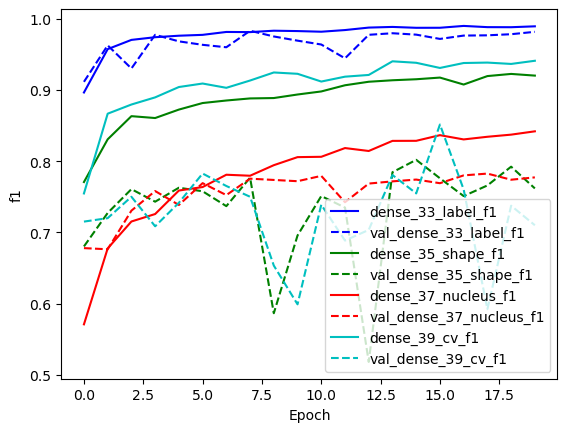

In [48]:
model_eval_comparison(histories['base'], metric='f1')

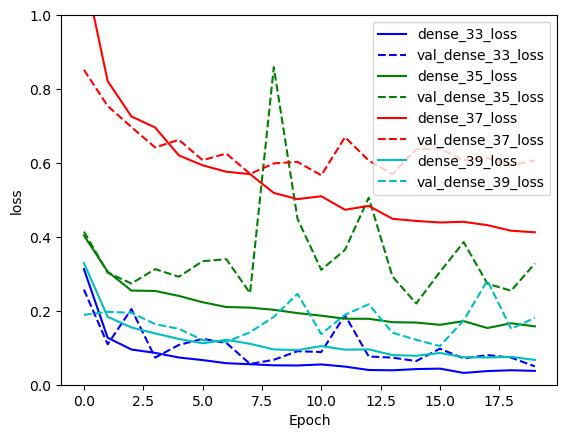

In [51]:
model_eval_comparison(histories['base'], metric='loss')

In [ ]:
reverse_mapping = {}

reverse_mapping['label'] = rev_type
reverse_mapping['cell_shape'] = rev_shape
reverse_mapping['nucleus_shape'] = rev_nucleus
reverse_mapping['cytoplasm_vacuole'] = rev_cv

def plot_confusion_matrix(model, val_batches, y_true, mapping_tables = reverse_mapping, features = features):

    fig, axs = plt.subplots(2,2,figsize=(12,12))
    axs = axs.ravel()

    y_pred = model.predict(val_batches)

    predictions = {}
    predictions[features[0]] = y_pred[0]
    predictions[features[1]] = y_pred[1]
    predictions[features[2]] = y_pred[2]
    predictions[features[3]] = y_pred[3]

    for i,f in enumerate(features):
        y_pred = predictions[f]
        if y_pred.ndim > 1 and y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)

        else:
            y_pred = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_true[f], y_pred)

        class_names = [mapping_tables[f][j] for j in sorted(mapping_tables[f].keys())]

    
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                ax=axs[i], xticklabels=class_names, yticklabels=class_names)
        axs[i].set_ylabel('True label')
        axs[i].set_xlabel('Predicted label')
        axs[i].set_title(f'Confusion Matrix for {f}')

    fig.tight_layout()

2025-09-07 00:57:34.819411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 9s 55ms/step


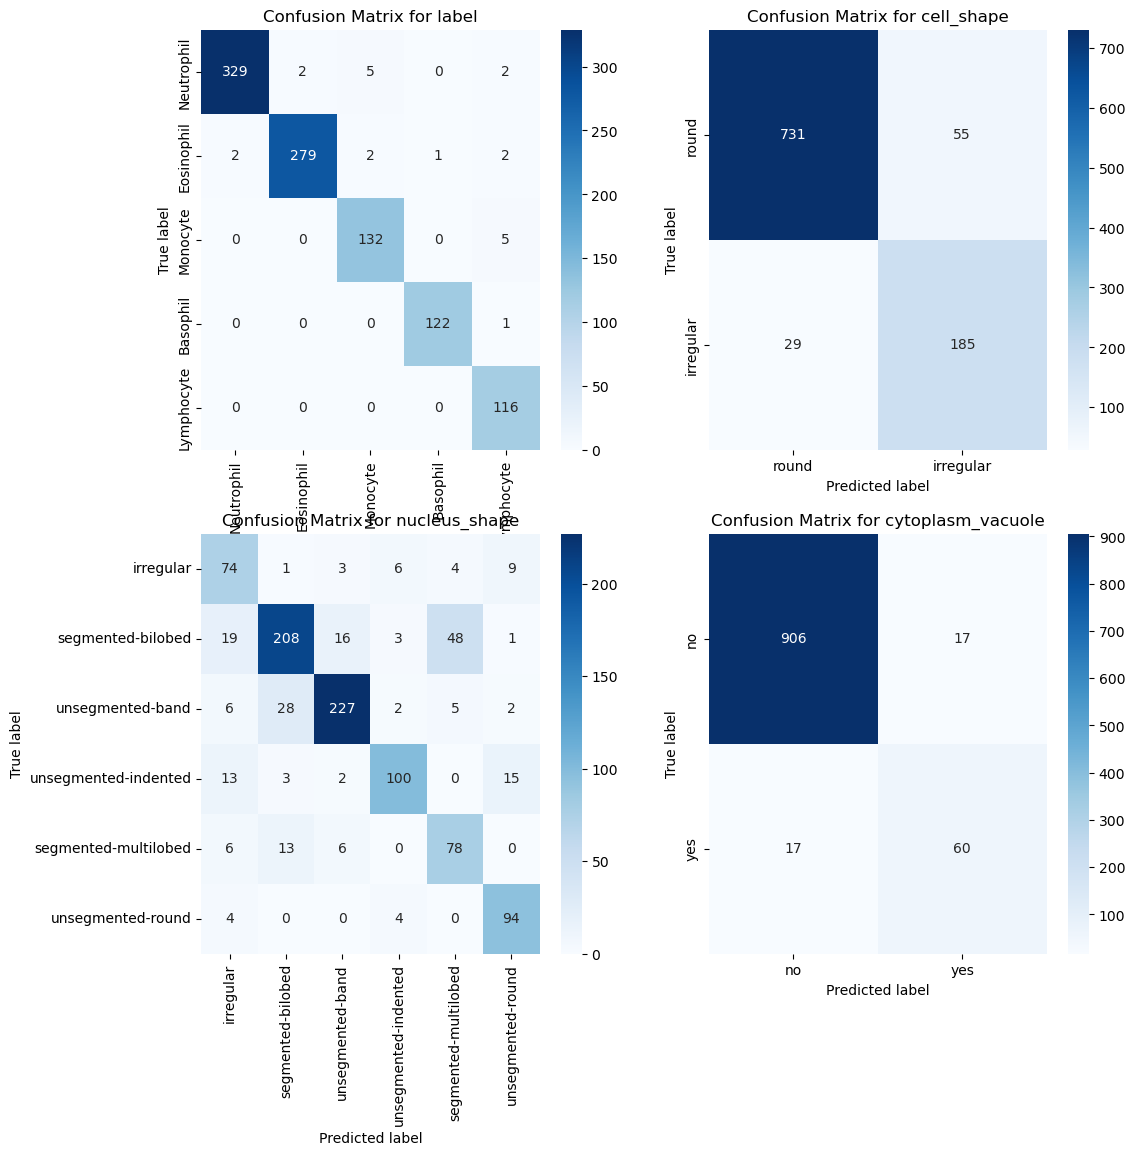

In [54]:
plot_confusion_matrix(baseline_model, val_batches, y_val)

### 4. EfficientNet

While trying to finetune the Efficient Net and ResNet we made two crutial observations:
- The obtained features perform signifiantly worse than the simple backbone we built. The weights were just not good enough to transform from imagenet to call data and therefore the idea of finetuning after training the heads did not make any sense. 
- EfficientNet provided significantly better results than ResNet

Therefore, we will utilize ResNet in an unfrozen status and train it normally compared to our baseline model. However, we do start with a lower initial training rate. 

In [ ]:
efficientnet_model = define_model(base='EfficientNetV2B0', trainable=True)

efficientnet_model.summary()

In [ ]:
initial_lr = 0.001
batches_per_epoch = train_size//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=batches_per_epoch,
    decay_rate=0.95,
    staircase=False
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

efficientnet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=[
        "categorical_crossentropy",   
        "binary_crossentropy",        
        "categorical_crossentropy",   
        "binary_crossentropy"         
        ],
        metrics=[[multiclass_f1(5, name='label_f1')],
                 [binary_f1(name='shape_f1')],
                 [multiclass_f1(6, name='nucleus_f1')],
                 [binary_f1(name='cv_f1')]
                 ]
)
        
histories['EffNet'] = efficientnet_model.fit(train_batches,
                                       epochs=30,
                                       validation_data=val_batches,
                                       callbacks = [early_stop],
                                       verbose=1,
)

In [ ]:
model_eval_comparison(histories['EffNet'], metric='f1')

In [ ]:
model_eval_comparison(histories['EffNet'], metric='loss')

In [ ]:
plot_confusion_matrix(efficientnet_model, val_batches, y_val)

I trained a neural network on images to detect (cell type, nucleus shape, cell form and cytoplasm_vacuole). I have a model utilizing ResNet50v2 as a baseline with some additional dense layers. When visualizing the training and validation f1 score I have multiple problems: - The training for some of the heads seems very bad while for example the cell type seems reasonably good. The validation is fluxuating extremely sometimes even hitting zero. What could be some of the causes? I thought - I have to deal with class imbalances which could explain the fluxuations as some target classes might be heavily underrepresented in the validation set and it might predict just a few instances of that class. What happens to f1 score in a multiclass setting if one class has no correct predictions. - Maybe the training rate is too high and the model can overfit. But image augmentations change the training data such that it adapts to the new pictures. Do data augmentations get applied each training epoch new or do they remain the same? - Maybe the baseline of ResNet doesn't work as well for thee medical images. Might need finetuning or a different model.


Try weighted losses (class weights or focal loss) to stabilize learning for rare classes.

Track both macro-F1 and micro-F1 — micro will tell you if the overall accuracy trend is stable, macro highlights imbalance.

Try LR scheduling (warmup, cosine decay, or reduce-on-plateau).

Data Exploration: Open Dataset and explore a few example pictures. 
Data Loader: Data Augmentation,
Model Design: Read some articles, find a model to orientate by. Use pre-existing/trained model! Build fine details of what will be important. Keep FC layers small to reduce used parameters, we are looking for local structure. Test different activation functions! What is the loss function we are creating? How are we choosing the optimizer. Include Gradient clipping/ previous layer connection to avoid exploding/vanishing gradients. Try momentum. Use BAtch Normalization (remove bias before), 
Compare to simple base models, a simple CNN with maybe two hidden layers. Regularization: Data Augmentation, Dropout,?, L2, l1? 

how does the output need to look like?  Classification of bloodcell type (0-4), cell shape(round, irregular),  Cytoplasm Vacuole (y/n), nucleeus shape (0-5)

## TODO 
- Find more models to use as base? Maybe something trained on cells?
- 